In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
from pycontrails.physics import geo, thermo, units, constants


In [2]:
job_id = 558038

In [3]:
params = pd.read_pickle("outputs/" + repr(job_id) + "/params_" + repr(job_id) + ".pkl")
params

{'fl_params': {'t0_fl': Timestamp('2022-01-20 13:00:00'),
  'rt_fl': Timedelta('0 days 01:00:00'),
  'ts_fl': Timedelta('0 days 00:02:00'),
  'ac_type': 'A320',
  'fl0_speed': 100.0,
  'fl0_heading': 45.0,
  'fl0_coords0': (0.1, 0.125, 12500),
  'sep_dist': (5000, 2000, 0),
  'n_ac': 1},
 'plume_params': {'dt_integration': Timedelta('0 days 00:02:00'),
  'max_age': Timedelta('0 days 01:00:00'),
  'depth': 50.0,
  'width': 50.0,
  'shear': 0.01,
  'hres_pl': 0.05,
  'vres_pl': 500},
 'sim_params': {'t0_sim': Timestamp('2022-01-20 12:00:00'),
  'rt_sim': Timedelta('0 days 12:00:00'),
  'ts_sim': Timedelta('0 days 00:00:20'),
  'lat_bounds': (0.0, 1.0),
  'lon_bounds': (0.0, 1.0),
  'alt_bounds': (12000, 13000),
  'hres_sim': 0.05,
  'vres_sim': 500,
  'eastward_wind': 0.0,
  'northward_wind': 0.0,
  'lagrangian_tendency_of_air_pressure': 0.0,
  'species_out': array([3, 4, 5, 6, 8, 9])}}

In [4]:
fl = pd.read_pickle("outputs/" + repr(job_id) + "/fl_" + repr(job_id) + ".pkl")
fl

,longitude,latitude,altitude,time,air_temperature,specific_humidity,true_airspeed,flight_id,aircraft_mass,engine_efficiency,...,NO,NO2,CO,HCHO,CH3CHO,C2H4,C3H6,C2H2,BENZENE,waypoint
0,0.125000,0.100000,12500.0,2022-01-20 13:00:00,212.263516,0.000219,100.230014,0.0,62518.613860,0.099880,...,2.048795,0.107831,0.062205,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,0
1,0.201229,0.176736,12500.0,2022-01-20 13:02:00,212.259403,0.000218,100.229809,0.0,62376.929746,0.099880,...,2.049022,0.107843,0.062205,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,1
2,0.277457,0.253473,12500.0,2022-01-20 13:04:00,212.255158,0.000218,100.229514,0.0,62235.235247,0.099881,...,2.049256,0.107856,0.062206,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,2
3,0.353686,0.330209,12500.0,2022-01-20 13:06:00,212.250782,0.000218,100.229130,0.0,62093.530027,0.099881,...,2.049498,0.107868,0.062206,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,3
4,0.429914,0.406945,12500.0,2022-01-20 13:08:00,212.246275,0.000217,100.228656,0.0,61951.813748,0.099881,...,2.049747,0.107881,0.062207,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,4
5,0.506143,0.483682,12500.0,2022-01-20 13:10:00,212.241637,0.000217,100.228093,0.0,61810.086073,0.099882,...,2.050005,0.107895,0.062208,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,5
6,0.582371,0.560418,12500.0,2022-01-20 13:12:00,212.236868,0.000217,100.227441,0.0,61668.346665,0.099882,...,2.050270,0.107909,0.062208,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,6
7,0.658600,0.637154,12500.0,2022-01-20 13:14:00,212.231968,0.000216,100.229528,0.0,61526.595186,0.099884,...,2.050540,0.107923,0.062209,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,7
8,0.734838,0.713886,12500.0,2022-01-20 13:16:00,212.226937,0.000216,100.231527,0.0,61384.831486,0.099885,...,2.050818,0.107938,0.062210,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,8
9,0.811084,0.790613,12500.0,2022-01-20 13:18:00,212.221775,0.000215,100.230606,0.0,61243.055229,0.099885,...,2.051106,0.107953,0.062210,0.000728,0.000243,0.00091,0.000243,0.000243,0.000121,9


In [5]:
pl = pd.read_pickle("outputs/" + repr(job_id) + "/pl_" + repr(job_id) + ".pkl")
pl

,flight_id,waypoint,fuel_flow,true_airspeed,CO2,H2O,SO2,NO,NO2,CO,...,longitude,latitude,level,width,heading,sigma_yy,sigma_zz,sin_a,cos_a,altitude
0,0.0,0,1.180701,100.230014,447.721802,174.271461,0.119015,2.048795,0.107831,0.062205,...,0.125000,0.100000,178.645172,83.609285,NaN,8.738141e+02,544.404306,NaN,NaN,12500.0
1,0.0,0,1.180701,100.230014,447.721802,174.271461,0.119015,2.048795,0.107831,0.062205,...,0.125000,0.100000,178.645172,154.997098,44.997927,3.003013e+03,776.308612,0.707081,0.707132,12500.0
30,0.0,1,1.180787,100.229809,447.754616,174.284233,0.119023,2.049022,0.107843,0.062205,...,0.201229,0.176736,178.645172,83.605381,44.997927,8.737325e+02,544.234298,0.707081,0.707132,12500.0
2,0.0,0,1.180701,100.230014,447.721802,174.271461,0.119015,2.048795,0.107831,0.062205,...,0.125000,0.100000,178.645172,242.783522,44.998098,7.367980e+03,1008.212918,0.707083,0.707130,12500.0
31,0.0,1,1.180787,100.229809,447.754616,174.284233,0.119023,2.049022,0.107843,0.062205,...,0.201229,0.176736,178.645172,154.980249,44.997927,3.002360e+03,775.968595,0.707081,0.707132,12500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.0,9,1.181578,100.230606,448.054324,174.400892,0.119103,2.051106,0.107953,0.062210,...,0.811084,0.790613,178.645172,4963.891704,44.990574,3.080028e+06,7004.100044,0.706990,0.707223,12500.0
327,0.0,10,1.181578,100.230606,448.054324,174.400892,0.119103,2.051106,0.107953,0.062210,...,0.887331,0.867340,178.645172,4719.015699,44.990574,2.783639e+06,6771.168543,0.706990,0.707223,12500.0
299,0.0,9,1.181578,100.230606,448.054324,174.400892,0.119103,2.051106,0.107953,0.062210,...,0.811084,0.790613,178.645172,5212.113188,44.991162,3.395765e+06,7234.844873,0.706998,0.707216,12500.0
328,0.0,10,1.181578,100.230606,448.054324,174.400892,0.119103,2.051106,0.107953,0.062210,...,0.887331,0.867340,178.645172,4963.154936,44.991162,3.079113e+06,7001.835277,0.706998,0.707216,12500.0


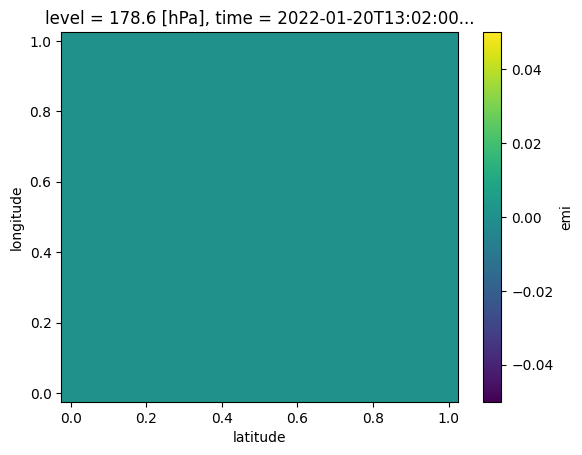

In [9]:
chem = xr.open_dataset("outputs/" + repr(job_id) +"/chem_" + repr(job_id) + ".nc")
chem["emi"].sel(emi_species="NO", time=pl["time"][0]).sel(level=178.6, method="nearest").plot()

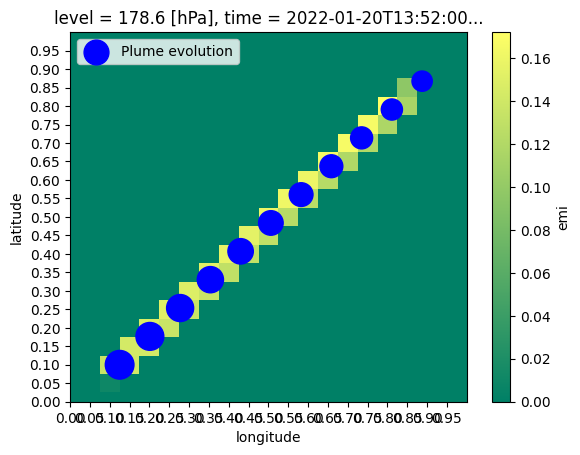

In [7]:
fig1, ax1 = plt.subplots()
ax1.set_xticks(np.arange(chem["longitude"][0], chem["longitude"][-1], 0.05))
ax1.set_yticks(np.arange(chem["latitude"][0], chem["latitude"][-1], 0.05))


ts = 25

# Plot the heatmap
heatmap_data = (
    chem.emi.sel(emi_species="NO", time=pl.time[ts])
    .sel(level=178.6, method="nearest")
    .transpose("latitude", "longitude")
)
heatmap_data.plot(ax=ax1, cmap="summer")  # You can choose a colormap of your preference


# scat_fl = ax1.scatter(
#     fl["longitude"].loc[fl["time"] == pl["time"][ts]],
#     fl["latitude"].loc[fl["time"] == pl["time"][ts]],
#     s=5,
#     c="red",
#     label="Flight path",
# )

scat_pl = ax1.scatter(
    pl["longitude"].loc[pl["time"] == pl["time"][ts]],
    pl["latitude"].loc[pl["time"] == pl["time"][ts]],
    s=10e-2 * pl["width"].loc[pl["time"] == pl["time"][ts]],
    c="blue",
    label="Plume evolution",
)

ax1.legend(loc="upper left")
ax1.set_xlim([params["sim_params"]["lon_bounds"][0], params["sim_params"]["lon_bounds"][1]])
ax1.set_ylim([params["sim_params"]["lat_bounds"][0], params["sim_params"]["lat_bounds"][1]])
# plt.grid()
plt.show()

In [10]:

"""Check if mass is conserved in the box model."""

mm = [30.01, 46.01, 28.01, 30.03, 44.05, 28.05, 42.08, 26.04, 78.11]  # g/mol
NA = 6.022e23  # Avogadro's number

total_vector_mass = 0
total_grid_mass = 0
for ts, time in enumerate(fl["time"][:-1]):
    print(time)
    # grab vector data
    for s, emi_species in enumerate(["NO"]):# self.boxm_ds_unstacked["emi_species"].data):
        
        vector_mass = fl[emi_species][ts]
    
        total_vector_mass += vector_mass

        # grab plume mass from grid data
        grid_concs = chem["emi"].sel(emi_species=emi_species, time=time).sel(level=178.6, method="nearest")

        if (grid_concs == 0).all():
            print("All values in grid_concs are zeros. Skipping processing.")
        else:
            grid_concs_over_zero = grid_concs.where(grid_concs > 0, drop=True)

            grid_mass = grid_concs_over_zero \
                * chem["M"].sel(time=time).sel(level=178.6, method="nearest") \
                * 1e-9 \
                * (mm[s] / NA) \
                * params["sim_params"]["vres_sim"] \
                * units.latitude_distance_to_m(params["sim_params"]["hres_sim"]) \
                * units.longitude_distance_to_m(params["sim_params"]["hres_sim"], (params["sim_params"]["lat_bounds"][0] + params["sim_params"]["lat_bounds"][1]) / 2) \
                * 1E+03 # convert to kg/m^3
                

            total_grid_mass = grid_mass.sum().values
            #total_grid_mass += grid_mass_sum
    
    print(total_vector_mass, total_grid_mass)

2022-01-20 13:00:00
All values in grid_concs are zeros. Skipping processing.
2.0487954416357503 0
2022-01-20 13:02:00
All values in grid_concs are zeros. Skipping processing.
4.097817222742115 0
2022-01-20 13:04:00
6.14707308290483 2.0489086113710395
2022-01-20 13:06:00
8.196570765012 4.098047432005601
2022-01-20 13:08:00
10.246318014770633 6.147424203140503
2022-01-20 13:10:00
12.296322581312406 8.197046669073465
2022-01-20 13:12:00
14.346592216861003 10.246922577223627
2022-01-20 13:14:00
16.39713195081323 12.29705967826872
2022-01-20 13:16:00
18.447949556445195 14.347464363019334
2022-01-20 13:18:00
20.49905553987926 16.39814303281132
